In [18]:
#Ning
#17 Nov
#Metaheuristics TP5

#import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math
import random

In [3]:
#preliminary look at the X.dat file and Y.dat file
#Note that 0 corresponds to 'two' and 1 corresponds to 'three'

def transfer_file_to_arrays (filename):
    
    images = []
    
    with open(filename, "r") as fp:
        for line in fp:
            line = line.split(",") #split values on ,
            for i in range(0, len(line)):
                line[i] = float(line[i]) #turn into a float
            line = np.array(line)
            images.append(line) #append in np array format

    return images

def get_labels (filename):
    labels = []
    with open(filename, "r") as fp:
        for line in fp:
            labels.append(float(line))
    return labels

In [4]:
images = transfer_file_to_arrays("X.dat")
print(len(images)) #confirm that we have 200 images stored
print(images[0].shape[0]) #confirm the shape of the image
labels = get_labels("Y.dat")
print(len(labels))

200
400
200


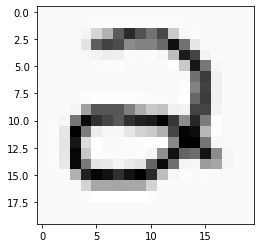

In [5]:
#show a sample of the image to see if we have one
plt.imshow(np.reshape(images[2], (20,20), order="F"), cmap="Greys")

In [7]:
def turn_two_to_one (theta1, theta2):
    return np.concatenate((theta1.flatten(), theta2.flatten()), axis=None)

def turn_one_to_two (big_theta):
    
    theta1 = np.reshape(big_theta[0:10025], (25,401)) #need to be careful here because of shape
    theta2 = np.reshape(big_theta[10025:], (1,26))
    
    return theta1, theta2

In [8]:
#testing
a = 6*np.zeros((25,401))-3
b = 6*np.full((1,26),1)-3

ab = turn_two_to_one(a,b)
c,d = turn_one_to_two(ab)

print(a==c)
print(b==d)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]


In [9]:
def sigmoid (X):
    return 1/(1+np.exp(-X))

def first_layer (picture):
    '''
    first layer's role is to download the 400 pixels of the picture
    and have one neuron that is the bias 
    '''
    #add bias neuron
    layer_n = picture.shape[0]
    first_layer = np.insert(picture, 0, 1.0) #add 1 as the bias
    
    return first_layer

def second_layer (layer, theta):
    '''
    second layer contains 25 neurons, plus 1 for the bias
    job is to matmul the first layer's output with theta, apply sigmoid function, add bias
    
    theta is the matrix of size (25, 401)
    '''
    
    res = np.matmul(theta, layer) #should be a matmul of sizes (25,401)(401,) -> (25,)
    
    #apply the sigmoid function
    res = sigmoid(res)
    
    res_n = res.shape[0] #should be 25
    
    second_layer = np.insert(res, 0, 1.0) #add 1 as the bias
    
    return second_layer

def third_layer (layer, theta):
    '''
    third layer contains 1 neuron
    job is to matmul the second layer's output with theta, apply sigmoid function, and return
    
    theta is the matrix of size (1, 26)
    '''
    
    res = np.matmul(theta, layer) #should be a matmul of sizes (1,26)(26,) -> (1,)
    
    #apply the sigmoid function
    res = sigmoid(res)
    
    return res #should be a singular value answer, our prediction

def nn_predict (image, big_theta):
    '''
    application of all three layers
    '''
    
    #temporary values
    theta1, theta2 = turn_one_to_two(big_theta)
    
    layer1 = first_layer(image)
    layer2 = second_layer(layer1, theta1) #this theta value will take on PSO's output once complete
    layer3 = third_layer(layer2, theta2)
    
    return layer3[0] #the prediction    

In [10]:
#do some testing with values, we should be able to get a value
test = images[2]
print(nn_predict(test, ab))

0.9525741268224334


Well, that certainly looks like a value. Good job kense. Time to start PSO

In [11]:
def calc_fitness(big_theta, images, labels):
    fitness = 0.0
    for k in range(0, len(labels)):
        fitness+=(labels[k] - nn_predict(images[k], big_theta))**2
    return fitness/len(labels)

In [12]:
t1 = np.random.rand(25,401)
t2 = np.random.rand(1,26)
bt = turn_two_to_one(t1,t2)
print(calc_fitness(bt, images, labels))

0.4999992629919221


In [13]:
def init_positions ():
    return 2*np.random.rand(25,401)-1, 2*np.random.rand(1,26)-1

def init_velocities ():
    return np.zeros((25,401)), np.zeros((1,26))

In [14]:
def PSO (n, tmax, images, labels):
    
    #variables
    global_best = np.array([None,float('inf')]) #global_best is (position, fitness)
    inertia_constant = 0.9
    c1 = 1.99811 #defined by the assignment as close to 2
    c2 = 1.99899
    t = 0
    vmax = 0.1
    
    #initialize particles -> (s, v, b)
    particles = []
    for i in range(n):
        s0_a, s0_b = init_positions()
        v0_a, v0_b = init_velocities()
        
        big_s0 = turn_two_to_one(s0_a, s0_b)
        big_v0 = turn_two_to_one(v0_a, v0_b)
        particle = np.array([big_s0, big_v0, big_s0]) #personal_best init is s0
        particles.append(particle)
   
    
    while(t < tmax):
        
        #for each particle
        for i in range(n):
            fit = calc_fitness(particles[i][0], images, labels) #positions are taken to calc fitness
            pbest_fit = calc_fitness(particles[i][2], images, labels)
            if fit <= pbest_fit: #if better than personal_best
                particles[i][2] = particles[i][0][:] #copy as new best
                
        #set global_best
        for i in range(n):
            fit = calc_fitness(particles[i][2], images, labels)
            if fit <= global_best[1]: #if personal_best better than global_best
                global_best[1] = fit
                global_best[0] = particles[i][2][:] #set new values for global
        
        #particle updates
        for i in range(n):
            r1 = random.random()
            r2 = random.random()
            
            #update velocity
            particles[i][1] = inertia_constant*particles[i][1] + c1*r1*(particles[i][2]-particles[i][0]) + c2*r2*(global_best[0]-particles[i][0])
        
            #velocity cutoff?
            particles[i][1][particles[i][1] > vmax] = vmax
            particles[i][1][particles[i][1] < -1*vmax] = -1*vmax
        
            #update positions
            particles[i][0] = particles[i][0] + particles[i][1]
            
            #correct particles out of range
            for x in range(len(particles[i][0])):
                particles[i][0][x] -(2*(particles[i][0][x]-1))
                particles[i][0][x] + (2*-1-particles[i][0][x])
        
        t = t + 1
    
    #get the stats of the global_best
    theta1, theta2 = turn_one_to_two(global_best[0]) #separate global_best's particle into thetas
    return theta1, theta2 #return

In [15]:
#testing
a,b = PSO(20, 200, images, labels)

print(a,b)

[[ 1.23052974 -0.25132168  0.09630181 ... -1.44251085  0.87655963
  -0.39313912]
 [-1.69120693 -0.83304209  0.42884806 ... -0.90531218  1.37398591
   1.83107494]
 [ 0.28786973 -0.45983586  0.31241736 ...  0.29435343 -0.90474082
  -1.25938518]
 ...
 [ 0.76122938  1.05937381  0.74554106 ...  1.18759362  0.52487228
  -1.35449155]
 [-0.14680765 -1.52604633 -1.24480789 ...  0.26474434 -1.46646198
  -1.90987452]
 [ 0.32530122  0.86431663  0.11379993 ...  0.32532388 -1.08372556
  -0.21969164]] [[-0.08933391  2.04324303 -1.17681853  2.57194634  0.22594376  0.56439394
   1.36717082  0.14258934 -1.91050157 -2.75970557  0.17122993  0.07546156
  -0.4574243   1.8245242   0.17613445 -0.32804758 -0.60562302 -0.62378694
  -1.81731313 -3.16024992  1.64242484  0.635771    0.92647091 -1.03921011
   0.38526205  0.27218909]]


In [21]:
#error testing
correct = 0
predictions = []
for i in range(len(images)):
    predict = nn_predict(images[i], turn_two_to_one(a,b))
    predictions.append(predict)
    truth = labels[i]
    
    if truth == int(predict+0.5):
        correct += 1
print(correct/len(labels))

1.0


In [23]:
predictions

[0.993190594165487,
 0.7817106451996119,
 0.8773166180293429,
 0.8373565020365438,
 0.9991872075343677,
 0.9697698274204231,
 0.9115314453899871,
 0.9826441507823865,
 0.9995058618446606,
 0.9875972407689736,
 0.9992813473483458,
 0.992480480436782,
 0.9998929371607637,
 0.8871328679845287,
 0.9972911424104663,
 0.9561482948370634,
 0.9996494180014334,
 0.9692292265038309,
 0.9698601458214076,
 0.9257917552084677,
 0.9751677186850238,
 0.9996857558503742,
 0.9992575361034871,
 0.9164928683790776,
 0.9985792993155753,
 0.9430737446861421,
 0.9025567093272756,
 0.9995281411692349,
 0.9736441710186516,
 0.9688803456511332,
 0.9437958137130646,
 0.9940105240794369,
 0.9963173531667447,
 0.979936910102686,
 0.9492541167598854,
 0.9957881924423712,
 0.9753922215559198,
 0.9980674506804712,
 0.9662556241457253,
 0.8602766945952789,
 0.9610137150537302,
 0.9970981042619254,
 0.9872567295131975,
 0.9970837346853132,
 0.9938218599027162,
 0.9916696376438756,
 0.9996431882246547,
 0.9979993590335

In [29]:
def calc_error(a,b,images,labels):
    #error testing
    correct = 0
    predictions = []
    for i in range(len(images)):
        predict = nn_predict(images[i], turn_two_to_one(a,b))
        predictions.append(predict)
        truth = labels[i]

        if truth != int(predict+0.5):
            correct += 1
            
    return correct/len(labels)

In [37]:
with open("./results/run_{0}".format(0), "w") as wp:
    wp.write(str(calc_fitness(turn_two_to_one(a,b),images,labels)))

In [ ]:
#plot fitness as a function of iteration number
fitnesses = []
for i in range(10, 110, 10): #we choose steps of 10
    a,b = PSO(20, i, images, labels)
    fitnesses.append(calc_fitness(turn_two_to_one(a,b),images,labels))

x_axis = [10,20,30,40,50,60,70,80,90,100]
fit_itr_data = pd.DataFrame({"x":x_axis, "y":fitnesses})

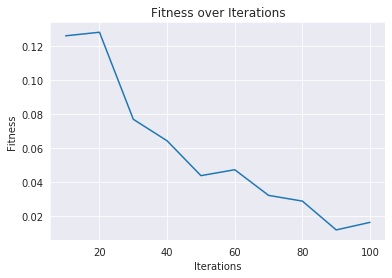

In [28]:
f = plt.figure()
with sb.axes_style("darkgrid"):
    ax = sb.lineplot(x="x",y="y",data=fit_itr_data)
    ax.title.set_text("Fitness over Iterations")
    ax.set(xlabel="Iterations", ylabel="Fitness")